<a href="https://colab.research.google.com/github/Offliners/HTML_2021Fall/blob/main/Final%20Project/fianl_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Directory**

```
data_dir
    ├── data
    │   ├── Test_IDs.csv
    │   ├── ...
    │   ├── status.csv
    ├── statistics
    │   ├── Churn Category_stat.png
    │   ├── ...
    │   ├── miss rate_stat.png
```

# **Display information of GPU**

In [1]:
!nvidia-smi

Sun Jan 16 15:48:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Download Dataset**

In [2]:
!mkdir "./data"
!mkdir "./statistics"
!gdown --id 1X5yz7QLAu4nttnCea4ALf6alae6Clv_o --output "./data/dataset.zip"
!unzip -q "./data/dataset.zip" -d "./data"
!rm "./data/dataset.zip"

Downloading...
From: https://drive.google.com/uc?id=1X5yz7QLAu4nttnCea4ALf6alae6Clv_o
To: /content/data/dataset.zip
100% 660k/660k [00:00<00:00, 96.8MB/s]


# **Import Some Packages**

In [65]:
import time
import numpy as np
import pandas as pd
from glob import glob
from collections import Counter
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, plot_confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# SMOTE
from imblearn.over_sampling import SMOTE

# SVM
from sklearn.svm import SVC

# DNN
import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

# XGBoost
from xgboost import XGBClassifier

# **Set a Random Seed**

In [66]:
# Set a random seed for reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# **CSV Files Combination**

In [67]:
train_path = './data/Train_IDs.csv'  # path to training data
test_path = './data/Test_IDs.csv'    # path to testing data

files = glob('./data/*.csv')
data_csv = []
data_csv.append(train_path)
for csv in files:
    if ('IDs' not in csv) and ('sample' not in csv) and ('population' not in csv) and ('result' not in csv):
        data_csv.append(csv)
  
print(data_csv)
df_list = [pd.read_csv(file) for file in data_csv]

['./data/Train_IDs.csv', './data/services.csv', './data/location.csv', './data/satisfaction.csv', './data/demographics.csv', './data/status.csv']


In [68]:
result_total = df_list[0]
for df in df_list[1:]:
    result_total = pd.merge(result_total, df, how='outer', on='Customer ID')

result_total.to_csv('./data/result_total.csv') # Save combined all result to result_total.csv

In [69]:
# There are 7043 total customer data
print(result_total)

     Customer ID  Count_x  ... Number of Dependents Churn Category
0     0650-BWOZN      1.0  ...                  0.0     Competitor
1     0562-FGDCR      1.0  ...                  0.0     Competitor
2     6688-UZPWD      1.0  ...                  NaN       No Churn
3     2905-KFQUV      1.0  ...                  0.0     Competitor
4     9720-JJJOR      1.0  ...                  0.0       No Churn
...          ...      ...  ...                  ...            ...
7038  6778-EICRF      NaN  ...                  0.0            NaN
7039  0772-GYEQQ      NaN  ...                  2.0            NaN
7040  5666-CYCYZ      NaN  ...                  0.0            NaN
7041  4893-GYUJU      NaN  ...                  0.0            NaN
7042  3426-NIYYL      NaN  ...                  2.0            NaN

[7043 rows x 48 columns]


In [70]:
# Train_IDs has 5634 customer data
result_train_total = df_list[0]
for df in df_list[1:]:
    result_train_total = pd.merge(result_train_total, df, how='left', on='Customer ID')

print(result_train_total)

     Customer ID  Count_x  ... Number of Dependents Churn Category
0     0650-BWOZN      1.0  ...                  0.0     Competitor
1     0562-FGDCR      1.0  ...                  0.0     Competitor
2     6688-UZPWD      1.0  ...                  NaN       No Churn
3     2905-KFQUV      1.0  ...                  0.0     Competitor
4     9720-JJJOR      1.0  ...                  0.0       No Churn
...          ...      ...  ...                  ...            ...
5629  1178-PZGAB      1.0  ...                  0.0            NaN
5630  4806-KEXQR      1.0  ...                  0.0            NaN
5631  8809-RIHDD      1.0  ...                  2.0       No Churn
5632  6663-JOCQO      1.0  ...                  3.0       No Churn
5633  7010-ZMVBF      1.0  ...                  0.0       No Churn

[5634 rows x 48 columns]


In [71]:
# Train_IDs has 4226 customer data with label
result_train = df_list[0]
for df in df_list[1:]:
    result_train = pd.merge(result_train, df, how='right', on='Customer ID')

print(result_train)

     Customer ID  Count_x  ... Number of Dependents Churn Category
0     0650-BWOZN      NaN  ...                  0.0     Competitor
1     0562-FGDCR      1.0  ...                  0.0     Competitor
2     6688-UZPWD      1.0  ...                  NaN       No Churn
3     2905-KFQUV      1.0  ...                  0.0     Competitor
4     9720-JJJOR      NaN  ...                  0.0       No Churn
...          ...      ...  ...                  ...            ...
4221  3313-QKNKB      NaN  ...                  NaN       No Churn
4222  8668-KNZTI      NaN  ...                  NaN       No Churn
4223  8809-RIHDD      NaN  ...                  2.0       No Churn
4224  6663-JOCQO      NaN  ...                  3.0       No Churn
4225  7010-ZMVBF      1.0  ...                  0.0       No Churn

[4226 rows x 48 columns]


In [72]:
# Train_IDs has 1408 customer data without label
result_train_miss = df_list[0]
for df in df_list[1:]:
    result_train_miss = pd.merge(result_train_miss, df, how='left', on='Customer ID')

result_train_miss = result_train_miss[result_train_miss['Churn Category'].isna()]

print(result_train_miss)

     Customer ID  Count_x  ... Number of Dependents Churn Category
6     0394-YONDK      1.0  ...                  NaN            NaN
7     0396-HUJBP      1.0  ...                  0.0            NaN
11    0684-AOSIH      1.0  ...                  2.0            NaN
14    1679-JRFBR      1.0  ...                  0.0            NaN
18    5533-NHFRF      NaN  ...                  0.0            NaN
...          ...      ...  ...                  ...            ...
5603  6330-JKLPC      1.0  ...                  NaN            NaN
5618  4549-ZDQYY      NaN  ...                  0.0            NaN
5622  9127-QRZMH      1.0  ...                  0.0            NaN
5629  1178-PZGAB      1.0  ...                  0.0            NaN
5630  4806-KEXQR      1.0  ...                  0.0            NaN

[1408 rows x 48 columns]


In [73]:
# Test_Ids has 1409 customer data
df_test = pd.read_csv(test_path)
result_test = df_test
for df in df_list[1:]:
    result_test = pd.merge(result_test, df, how='left', on='Customer ID')

print(result_test)

     Customer ID  Count_x  ... Number of Dependents Churn Category
0     9938-EKRGF      1.0  ...                  0.0            NaN
1     7379-POKDZ      1.0  ...                  0.0            NaN
2     0654-HMSHN      1.0  ...                  NaN            NaN
3     2045-BMBTJ      1.0  ...                  3.0            NaN
4     0701-TJSEF      1.0  ...                  0.0            NaN
...          ...      ...  ...                  ...            ...
1404  4587-VVTOX      1.0  ...                  NaN            NaN
1405  7716-YTYHG      NaN  ...                  0.0            NaN
1406  7649-PHJVR      NaN  ...                  0.0            NaN
1407  7855-DIWPO      1.0  ...                  3.0            NaN
1408  8197-BFWVU      1.0  ...                  NaN            NaN

[1409 rows x 48 columns]


In [74]:
print(result_total.dropna()) # Find customer with full data infomation

     Customer ID  Count_x  ... Number of Dependents   Churn Category
666   0454-OKRCT      1.0  ...                  2.0         No Churn
678   1735-XMJVH      1.0  ...                  0.0         No Churn
1799  1245-HARPS      1.0  ...                  0.0  Dissatisfaction
2805  8445-DNBAE      1.0  ...                  0.0       Competitor
2883  8708-XPXHZ      1.0  ...                  0.0         No Churn
3062  9522-ZSINC      1.0  ...                  0.0         No Churn
4297  0836-SEYLU      1.0  ...                  0.0         No Churn
5146  7274-RTAPZ      1.0  ...                  1.0         No Churn

[8 rows x 48 columns]


In [75]:
result_cols = result_total.columns
print(result_cols)

Index(['Customer ID', 'Count_x', 'Quarter', 'Referred a Friend',
       'Number of Referrals', 'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Count_y', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Satisfaction Score', 'Count',
       'Gender', 'Age', 'Under 30', 'Senior Citizen', 'Married', 'Dependents',
       'Number of Dependents', 'Churn Category'],
      dtype='object')


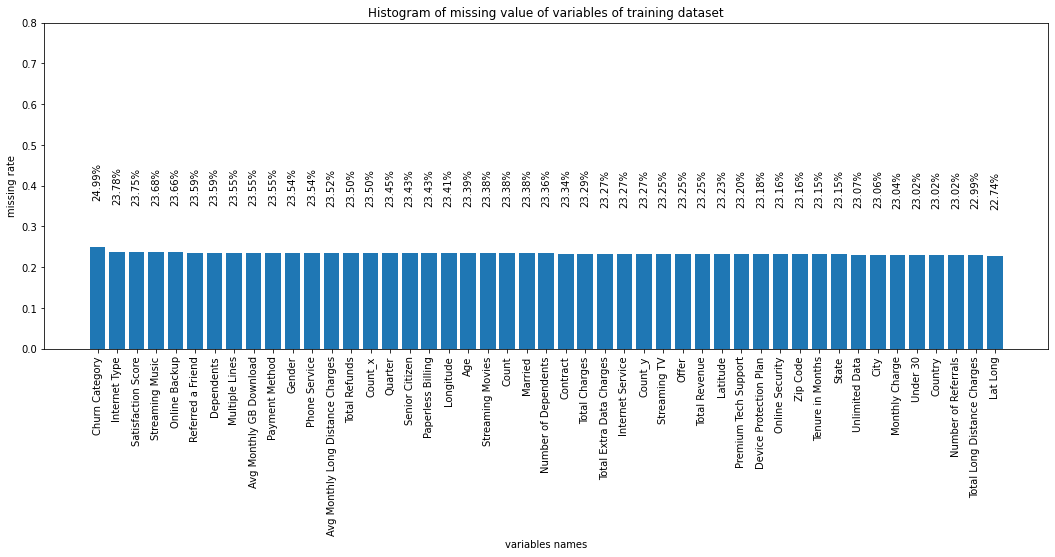

In [76]:
missing = result_train_total.isnull().sum().reset_index().rename(columns={0:'missNum'})
missing['missRate'] = missing['missNum'] / result_train_total.shape[0]
miss_analy = missing[missing.missRate > 0].sort_values(by='missRate', ascending=False)

fig = plt.figure(figsize=(18, 6))
plt.bar(np.arange(miss_analy.shape[0]), list(miss_analy.missRate.values), align='center')

plt.title('Histogram of missing value of variables of training dataset')
plt.xlabel('variables names')
plt.ylabel('missing rate')
plt.xticks(np.arange(miss_analy.shape[0]), list(miss_analy['index']))
plt.xticks(rotation=90)
for x, y in enumerate(list(miss_analy.missRate.values)):
    plt.text(x, y + 0.12, '{:.2%}'.format(y), ha='center', rotation=90)    

plt.ylim([0, 0.8])  
plt.savefig(f'./statistics/miss rate_train_stat.png')  
plt.show()
plt.close()

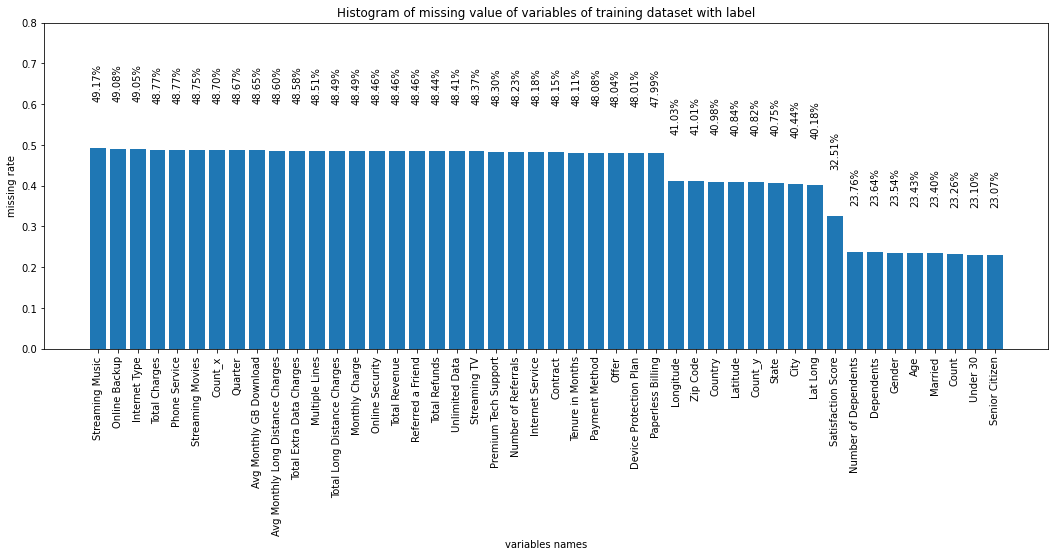

In [77]:
missing = result_train.isnull().sum().reset_index().rename(columns={0:'missNum'})
missing['missRate'] = missing['missNum'] / result_train.shape[0]
miss_analy = missing[missing.missRate > 0].sort_values(by='missRate', ascending=False)

fig = plt.figure(figsize=(18, 6))
plt.bar(np.arange(miss_analy.shape[0]), list(miss_analy.missRate.values), align='center')

plt.title('Histogram of missing value of variables of training dataset with label')
plt.xlabel('variables names')
plt.ylabel('missing rate')
plt.xticks(np.arange(miss_analy.shape[0]), list(miss_analy['index']))
plt.xticks(rotation=90)
for x, y in enumerate(list(miss_analy.missRate.values)):
    plt.text(x, y + 0.12, '{:.2%}'.format(y), ha='center', rotation=90)    

plt.ylim([0, 0.8])  
plt.savefig(f'./statistics/miss rate_train_stat.png')  
plt.show()
plt.close()

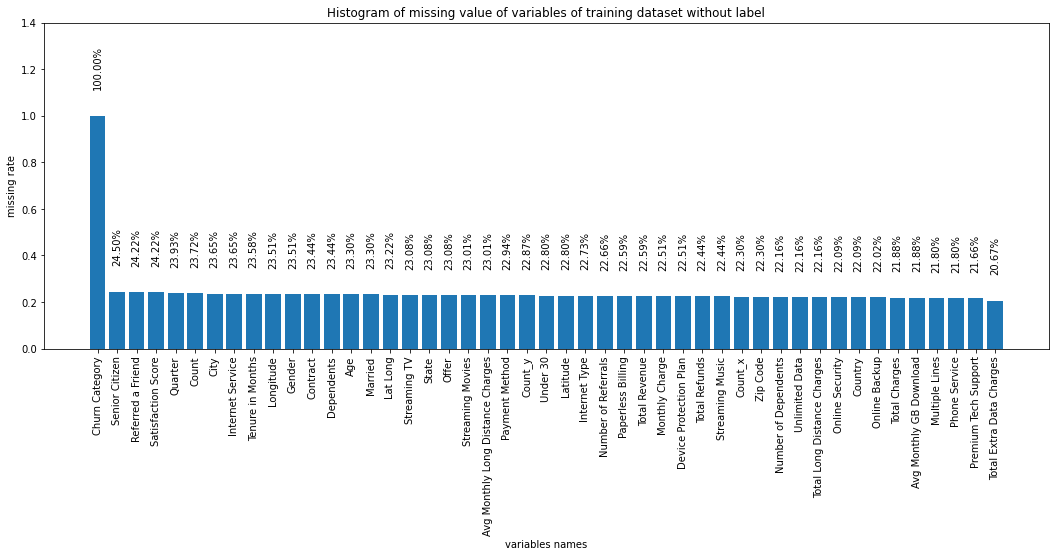

In [78]:
missing = result_train_miss.isnull().sum().reset_index().rename(columns={0:'missNum'})
missing['missRate'] = missing['missNum'] / result_train_miss.shape[0]
miss_analy = missing[missing.missRate > 0].sort_values(by='missRate', ascending=False)

fig = plt.figure(figsize=(18, 6))
plt.bar(np.arange(miss_analy.shape[0]), list(miss_analy.missRate.values), align='center')

plt.title('Histogram of missing value of variables of training dataset without label')
plt.xlabel('variables names')
plt.ylabel('missing rate')
plt.xticks(np.arange(miss_analy.shape[0]), list(miss_analy['index']))
plt.xticks(rotation=90)
for x, y in enumerate(list(miss_analy.missRate.values)):
    plt.text(x, y + 0.12, '{:.2%}'.format(y), ha='center', rotation=90)    

plt.ylim([0, 1.4])  
plt.savefig(f'./statistics/miss rate_train_stat.png')  
plt.show()
plt.close()

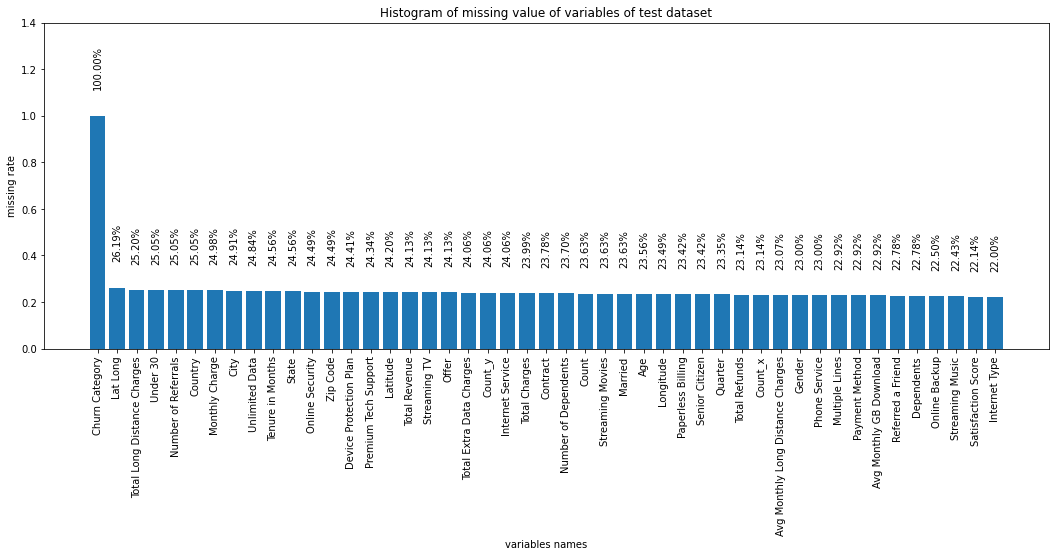

In [79]:
missing = result_test.isnull().sum().reset_index().rename(columns={0:'missNum'})
missing['missRate'] = missing['missNum'] / result_test.shape[0]
miss_analy = missing[missing.missRate > 0].sort_values(by='missRate', ascending=False)

fig = plt.figure(figsize=(18, 6))
plt.bar(np.arange(miss_analy.shape[0]), list(miss_analy.missRate.values), align='center')

plt.title('Histogram of missing value of variables of test dataset')
plt.xlabel('variables names')
plt.ylabel('missing rate')
plt.xticks(np.arange(miss_analy.shape[0]), list(miss_analy['index']))
plt.xticks(rotation=90)
for x, y in enumerate(list(miss_analy.missRate.values)):
    plt.text(x, y + 0.12, '{:.2%}'.format(y), ha='center', rotation=90)    

plt.ylim([0, 1.4])  
plt.savefig(f'./statistics/miss rate_test_stat.png')  
plt.show()
plt.close()

# **Statistics and Data Preprocessing**

In [80]:
result_train_total_copy = result_train_total.copy(deep=True)
result_train_copy = result_train.copy(deep=True) # TODO
result_train_miss_copy = result_train_miss.copy(deep=True)
result_test_copy = result_test.copy(deep=True)
def label_statistics(label):
    freq = result_train_total.groupby(label).size()

    names = [name for name, _ in freq.items()]
    names.append('Nan')
    counts = [count for _, count in freq.items()]
    counts.append(len(result_train[label]) - sum(counts))

    fig = plt.figure(figsize=(8, 6))
    x = np.arange(len(names))
    plt.bar(x, counts)
    plt.xticks(x, names, rotation=15)
    plt.title(f'Statistics of {label}')
    plt.savefig(f'./statistics/Statistics of {label}.png')
    print(f'Statistics of {label}.png saved')
    plt.close()

In [81]:
need_statistics_col = ['Churn Category', 'Satisfaction Score', 
       'Gender', 'Under 30', 'Senior Citizen', 'Married', 'Dependents',
       'Number of Dependents', 'Country', 'State', 'City', 'Quarter',
       'Referred a Friend', 'Number of Referrals', 'Offer',
       'Phone Service', 'Multiple Lines', 'Internet Service', 'Internet Type',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Zip Code']

# Replace NaN with the most frequent label
for need_col in need_statistics_col:
    label_statistics(need_col)

    # Encode target labels with value
    le = LabelEncoder()
    result_train_copy[need_col] = le.fit_transform(result_train_copy[need_col])

    if need_col == 'Churn Category':
        encoder_map = dict(zip(le.classes_, le.transform(le.classes_)))
    
    result_train_miss_copy[need_col] = le.fit_transform(result_train_miss_copy[need_col])
    result_test_copy[need_col] = le.fit_transform(result_test_copy[need_col])

Statistics of Churn Category.png saved
Statistics of Satisfaction Score.png saved
Statistics of Gender.png saved
Statistics of Under 30.png saved
Statistics of Senior Citizen.png saved
Statistics of Married.png saved
Statistics of Dependents.png saved
Statistics of Number of Dependents.png saved
Statistics of Country.png saved
Statistics of State.png saved
Statistics of City.png saved
Statistics of Quarter.png saved
Statistics of Referred a Friend.png saved
Statistics of Number of Referrals.png saved
Statistics of Offer.png saved
Statistics of Phone Service.png saved
Statistics of Multiple Lines.png saved
Statistics of Internet Service.png saved
Statistics of Internet Type.png saved
Statistics of Online Security.png saved
Statistics of Online Backup.png saved
Statistics of Device Protection Plan.png saved
Statistics of Premium Tech Support.png saved
Statistics of Streaming TV.png saved
Statistics of Streaming Movies.png saved
Statistics of Streaming Music.png saved
Statistics of Unlimi

In [82]:
population = pd.read_csv('./data/population.csv')
population = population.drop('Zip Code', axis=1)
population.rename({'ID':'Zip Code'}, axis=1, inplace=True)
result_train_copy = pd.merge(result_train_copy, population, how='left', on='Zip Code')
result_train_miss_copy = pd.merge(result_train_miss_copy, population, how='left', on='Zip Code')
result_test_copy = pd.merge(result_test_copy, population, how='left', on='Zip Code')

need_avg_col = [item for item in result_cols if item not in need_statistics_col]
need_avg_col.append('Population')

def data_imputation(train_dataset, miss_dataset, test_dataset, target):
    imputer = IterativeImputer(max_iter=2, initial_strategy='mean', imputation_order='descending', random_state=seed)
    imputer.fit(train_dataset)
    train_dataset = imputer.transform(train_dataset)
    miss_dataset = imputer.transform(miss_dataset)
    test_dataset = imputer.transform(test_dataset)

    train_dataset = pd.DataFrame(train_dataset, columns=target)
    miss_dataset = pd.DataFrame(miss_dataset, columns=target)
    test_dataset = pd.DataFrame(test_dataset, columns=target)

    return train_dataset, miss_dataset, test_dataset

col_names = list(result_cols.values)
col_names.remove('Customer ID')
col_names.remove('Lat Long')
col_names.remove('Churn Category')
col_names.append('Population')

for label in col_names:
    target = [label, 'Churn Category']
    result_train_copy[target], result_train_miss_copy[target], result_test_copy[target] = data_imputation(result_train_copy[target], result_train_miss_copy[target], result_test_copy[target], target)

In [83]:
result_train_copy = result_train_copy.drop('Customer ID', axis=1)
result_train_copy = result_train_copy.drop('Lat Long', axis=1)
result_train_miss_copy = result_train_miss_copy.drop('Customer ID', axis=1)
result_train_miss_copy = result_train_miss_copy.drop('Lat Long', axis=1)
result_test_copy = result_test_copy.drop('Customer ID', axis=1)
result_test_copy = result_test_copy.drop('Lat Long', axis=1)

print(result_train_copy)

      Count_x  Quarter  ...  Churn Category  Population
0         1.0      1.0  ...             1.0       660.0
1         1.0      0.0  ...             1.0     37280.0
2         1.0      0.0  ...             3.0      2899.0
3         1.0      0.0  ...             1.0     26831.0
4         1.0      1.0  ...             3.0       660.0
...       ...      ...  ...             ...         ...
4221      1.0      1.0  ...             3.0       660.0
4222      1.0      1.0  ...             3.0       660.0
4223      1.0      1.0  ...             3.0       660.0
4224      1.0      1.0  ...             3.0       660.0
4225      1.0      0.0  ...             3.0     27047.0

[4226 rows x 47 columns]


In [84]:
# Find the correlation of columns
cor_matrix = result_train_copy.corr().abs()
print(cor_matrix['Churn Category'])

Count_x                                   NaN
Quarter                              0.026687
Referred a Friend                    0.034992
Number of Referrals                  0.065368
Tenure in Months                     0.294675
Offer                                0.035282
Phone Service                        0.004287
Avg Monthly Long Distance Charges    0.006149
Multiple Lines                       0.021953
Internet Service                     0.021609
Internet Type                        0.038484
Avg Monthly GB Download              0.071765
Online Security                      0.061089
Online Backup                        0.031315
Device Protection Plan               0.028059
Premium Tech Support                 0.053844
Streaming TV                         0.008534
Streaming Movies                     0.000321
Streaming Music                      0.015176
Unlimited Data                       0.013768
Contract                             0.111203
Paperless Billing                 

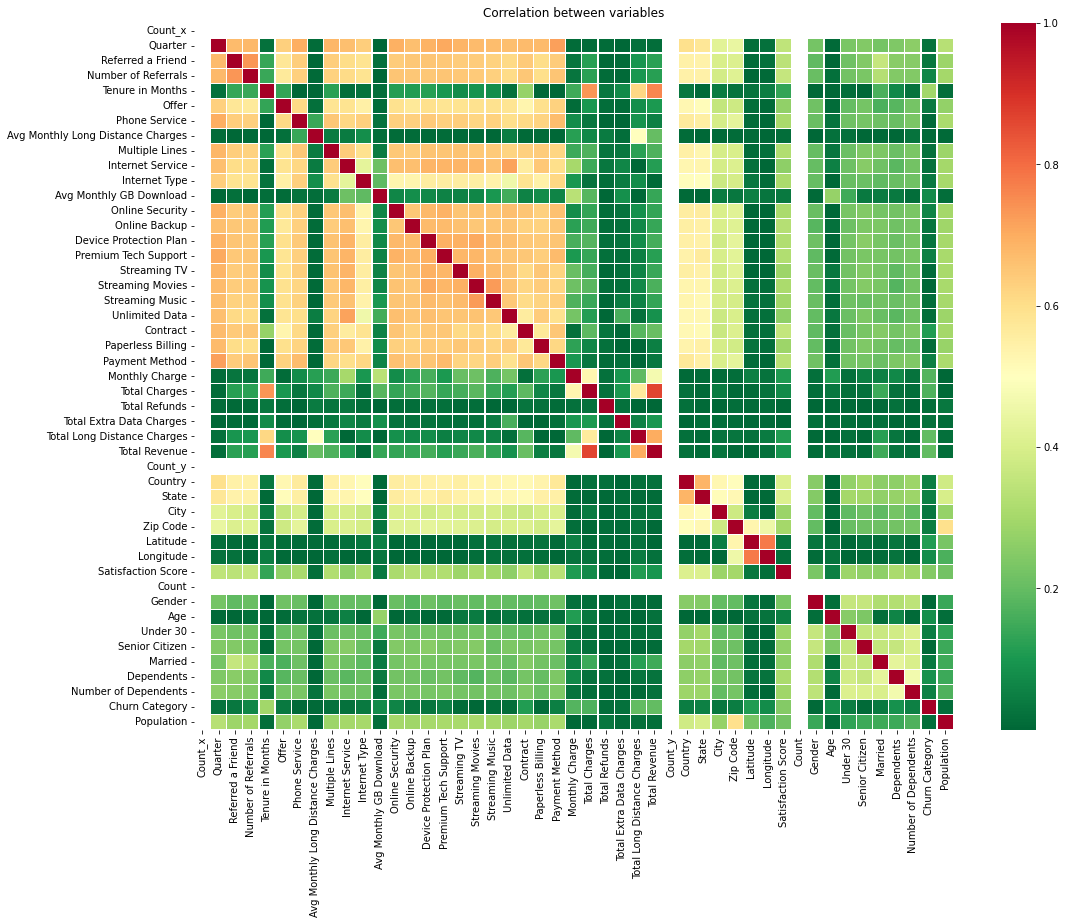

In [85]:
plt.figure(figsize=(17, 13))
cor_matrix_copy = cor_matrix.copy(deep=True)
cor_matrix_copy.dropna()
ax = sns.heatmap(cor_matrix_copy, xticklabels=cor_matrix_copy.columns, yticklabels=cor_matrix_copy.columns, 
                 linewidths=0.2, cmap="RdYlGn_r", fmt="s")

plt.title("Correlation between variables")
plt.show()

In [86]:
useless_feature = [index for index, value in cor_matrix['Churn Category'].items() if value < 0.05 or pd.isnull(value)]
print(useless_feature)

['Count_x', 'Quarter', 'Referred a Friend', 'Offer', 'Phone Service', 'Avg Monthly Long Distance Charges', 'Multiple Lines', 'Internet Service', 'Internet Type', 'Online Backup', 'Device Protection Plan', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Paperless Billing', 'Payment Method', 'Total Refunds', 'Total Extra Data Charges', 'Count_y', 'Country', 'City', 'Zip Code', 'Count', 'Gender', 'Under 30', 'Senior Citizen', 'Married', 'Population']


In [87]:
def dropColumns(label):
    global result_train_copy, result_train_miss_copy, result_test_copy
    result_train_copy = result_train_copy.drop(label, axis=1)
    result_train_miss_copy = result_train_miss_copy.drop(label, axis=1)
    result_test_copy = result_test_copy.drop(label, axis=1)

In [88]:
# Throw away the data columns whose correlation to Churn Category is less than 0.05
for item in useless_feature:
    dropColumns(item)

In [89]:
result_train_copy.to_csv('./data/result_after_preprocessing.csv') # Save after preprocessing result to result_after_preprocessing.csv
feature_amount = len(result_train_copy.columns)

print(result_train_copy)
print(result_train_miss_copy)
print(result_test_copy)

      Number of Referrals  ...  Churn Category
0                    11.0  ...             1.0
1                     0.0  ...             1.0
2                     4.0  ...             3.0
3                     0.0  ...             1.0
4                    11.0  ...             3.0
...                   ...  ...             ...
4221                 11.0  ...             3.0
4222                 11.0  ...             3.0
4223                 11.0  ...             3.0
4224                 11.0  ...             3.0
4225                  8.0  ...             3.0

[4226 rows x 18 columns]
      Number of Referrals  ...  Churn Category
0                     0.0  ...             0.0
1                     2.0  ...             0.0
2                     1.0  ...             0.0
3                    10.0  ...             0.0
4                     0.0  ...             0.0
...                   ...  ...             ...
1403                  0.0  ...             0.0
1404                 12.0  ...    

# **Balance Data**

In [90]:
y_train = result_train_copy['Churn Category'].values
X_train = result_train_copy.drop('Churn Category', axis=1)

X_train_miss = result_train_miss_copy.drop('Churn Category', axis=1)

In [91]:
print(f"normal data distribution: {Counter(y_train)}")

class_weight = dict(Counter(y_train))

smo = SMOTE(random_state=seed)
X_train, y_train = smo.fit_resample(X_train, y_train)

print(f"SMOTE data distribution: {Counter(y_train)}")

normal data distribution: Counter({3.0: 3118, 1.0: 490, 0.0: 201, 2.0: 177, 5.0: 124, 4.0: 116})
SMOTE data distribution: Counter({1.0: 3118, 3.0: 3118, 2.0: 3118, 4.0: 3118, 5.0: 3118, 0.0: 3118})


# **Split and Standardize Data**

In [92]:
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

ss = StandardScaler().fit(train_x)
train_x = ss.transform(train_x)
val_x = ss.transform(val_x)
miss_x = ss.transform(X_train_miss)

X_test = result_test_copy.drop('Churn Category', axis=1)
X_test_std = ss.transform(X_test)

class_weight = {k: train_x.shape[0] / v for k, v in class_weight.items()}
class_weight = collections.OrderedDict(sorted(class_weight.items()))
print(class_weight)

OrderedDict([(0.0, 74.45771144278606), (1.0, 30.542857142857144), (2.0, 84.55367231638418), (3.0, 4.799871712636305), (4.0, 129.01724137931035), (5.0, 120.69354838709677)])


# **SVM Train**

In [93]:
svm = SVC(kernel='rbf', gamma=0.1, C=10, class_weight=class_weight)

start_time = time.time()
model = svm.fit(train_x, train_y)
end_time = time.time()

print(f'Training use {round(end_time - start_time, 3)}s')

Training use 4.983s


In [94]:
y_train_predict = svm.predict(train_x)
Ein = np.mean(np.array(y_train_predict) != train_y)
F1in = metrics.f1_score(train_y, y_train_predict, average='macro')  
print(f'Ein = {round(Ein, 5)}')
print(f'F1_in = {round(F1in, 5)}')

y_val_predict = svm.predict(val_x)
Eval = np.mean(np.array(y_val_predict) != val_y)
F1val = metrics.f1_score(val_y, y_val_predict, average='macro')  
print(f'Eval = {round(Eval, 5)}')
print(f'F1_val = {round(F1val, 5)}')

Ein = 0.0
F1_in = 1.0
Eval = 0.02084
F1_val = 0.97883


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


{'Attitude': 0, 'Competitor': 1, 'Dissatisfaction': 2, 'No Churn': 3, 'Other': 4, 'Price': 5}


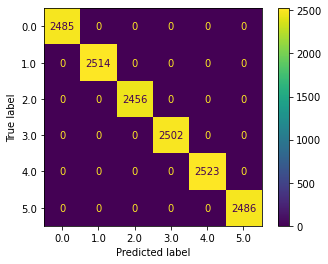

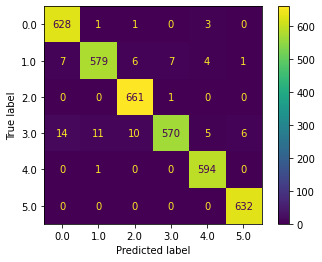

In [95]:
plot_confusion_matrix(model, train_x, train_y)
plot_confusion_matrix(model, val_x, val_y)
print(encoder_map)

In [96]:
print(classification_report(train_y, y_train_predict))
print(classification_report(val_y, y_val_predict))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2485
         1.0       1.00      1.00      1.00      2514
         2.0       1.00      1.00      1.00      2456
         3.0       1.00      1.00      1.00      2502
         4.0       1.00      1.00      1.00      2523
         5.0       1.00      1.00      1.00      2486

    accuracy                           1.00     14966
   macro avg       1.00      1.00      1.00     14966
weighted avg       1.00      1.00      1.00     14966

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       633
         1.0       0.98      0.96      0.97       604
         2.0       0.97      1.00      0.99       662
         3.0       0.99      0.93      0.95       616
         4.0       0.98      1.00      0.99       595
         5.0       0.99      1.00      0.99       632

    accuracy                           0.98      3742
   macro avg       0.98

# **SVM Test**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


{'Attitude': 0, 'Competitor': 1, 'Dissatisfaction': 2, 'No Churn': 3, 'Other': 4, 'Price': 5}


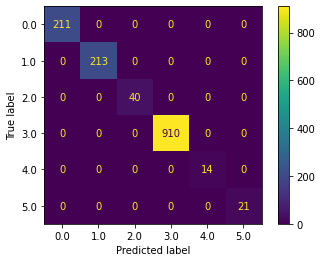

In [97]:
y_test = svm.predict(X_test_std)
plot_confusion_matrix(model, X_test_std, y_test)
print(encoder_map)

In [98]:
svm_submit_result = './svm_result.csv'

new_encoder_map = {'No Churn':0, 'Competitor': 1, 'Dissatisfaction':2, 'Attitude': 3, 'Price':4, 'Other':5}

with open(svm_submit_result, 'w') as f:
    f.write('Customer ID,Churn Category\n')
    for i in range(len(df_test.values)):
        id = str(df_test.values[i]).replace('[\'', '')
        id = id.replace('\']', '')
        pred = new_encoder_map.get(list(encoder_map.keys())[list(encoder_map.values()).index(y_test[i])])
        f.write(f'{id},{pred}\n')

In [99]:
from google.colab import files

files.download(svm_submit_result)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Deep Neural Network Train**

In [100]:
class IBMDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = torch.from_numpy(X).float()
        if y is not None:
            y = y.astype(np.int)
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)

In [101]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(feature_amount - 1, 256)
        self.layer2 = nn.Linear(256, 128)
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(128)
        self.out = nn.Linear(128, 6)
        self.dp = nn.Dropout(0.1)
        self.act_fn = nn.LeakyReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.act_fn(x)
        x = self.bn1(x)
        x = self.dp(x)

        x = self.layer2(x)
        x = self.act_fn(x)
        x = self.bn2(x)
        x = self.dp(x)
        
        x = self.out(x)
        
        return x

# classifier = Classifier()
# summary(classifier, X_train.shape, device="cpu")

In [102]:
def get_pseudo_labels(dataset, model, batch_size, threshold=0.99):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    softmax = nn.Softmax(dim=-1)

    pseudo_x = []
    pseudo_y = []
    for i, data in enumerate(data_loader):
        inputs = data

        with torch.no_grad():
            logits = model(inputs.to(device))

        probs = softmax(logits)
        label = torch.where(torch.max(probs, dim=1)[0] > threshold, torch.argmax(probs,dim=1), -1)
        label = label.cpu()
        for j in range(len(label)):
            if label[j] != -1:
                pseudo_x.append(data[j])
                pseudo_y.append(label[j])

    model.train()
    print(f"Pseudo Labeling : {len(pseudo_x)}")
    if len(pseudo_x) > 0:
        flag = 1
        pseudo_dataset = IBMDataset(torch.stack(pseudo_x, dim=0).numpy(), np.array(pseudo_y))
        return pseudo_dataset, len(pseudo_x), flag
    else:
        flag = 0
        return None, 0, flag
    

In [103]:
VAL_RATIO = 0.2
BATCH_SIZE = 64

percent = int(X_train.shape[0] * (1 - VAL_RATIO))
train_x, train_y, val_x, val_y = X_train[:percent], y_train[:percent], X_train[percent:], y_train[percent:]

ss = StandardScaler().fit(train_x)
train_x = ss.transform(train_x)
miss_x = ss.transform(X_train_miss)
val_x = ss.transform(val_x)
X_test_std = ss.transform(X_test)

print('Size of training set: {}'.format(train_x.shape))
print('Size of training set: {}'.format(miss_x.shape))
print('Size of validation set: {}'.format(val_x.shape))

Size of training set: (14966, 17)
Size of training set: (1408, 17)
Size of validation set: (3742, 17)


In [104]:
train_set = IBMDataset(train_x, train_y)
miss_set = IBMDataset(miss_x, None)
val_set = IBMDataset(val_x, val_y)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) # only shuffle the training data
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

In [105]:
# get device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE: {device}')

# training parameters
num_epoch = 3000             # number of training epoch
learning_rate = 0.001       # learning rate
callback_num = 400

# the path where checkpoint saved
model_path = './best_model.ckpt'

# create model, define a loss function, and optimizer
model = Classifier().to(device)
class_weight = [v for k, v in class_weight.items()]
criterion = nn.CrossEntropyLoss() # weight=torch.FloatTensor(class_weight).to(device)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=5e-4, lr=learning_rate)
scheduler = StepLR(optimizer, step_size=len(train_loader) * 200, gamma=0.1)

DEVICE: cuda


In [106]:
best_acc = 0.0
count = 0
start_time = time.time()
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []
for epoch in range(num_epoch):
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    # Pseudo Label
    pseudo_set, add_num, flag = get_pseudo_labels(miss_set, model, BATCH_SIZE)
    if flag:
        concat_dataset = ConcatDataset([train_set, pseudo_set])
        train_loader_semi = DataLoader(concat_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    else:
        train_loader_semi = train_loader
    # train_loader_semi = train_loader
    # training
    model.train() # set the model to training mode
    for i, data in enumerate(train_loader_semi):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() 
        outputs = model(inputs) 
        batch_loss = criterion(outputs, labels)
        _, train_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        batch_loss.backward() 
        optimizer.step()
        scheduler.step()

        train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
        train_loss += batch_loss.item()

    # validation
    if len(val_set) > 0:
        model.eval() # set the model to evaluation mode
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                batch_loss = criterion(outputs, labels) 
                _, val_pred = torch.max(outputs, 1) 
            
                val_acc += (val_pred.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
                val_loss += batch_loss.item()

            print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
                epoch + 1, num_epoch, train_acc/(len(train_set) + add_num), train_loss/len(train_loader_semi), val_acc/len(val_set), val_loss/len(val_loader)
            ))

            # Record Training and validation info
            train_acc_list.append(train_acc/(len(train_set) + add_num))
            train_loss_list.append(train_loss/len(train_loader_semi))
            val_acc_list.append(val_acc/len(val_set))
            val_loss_list.append(val_loss/len(val_loader))

            # if the model improves, save a checkpoint at this epoch
            count += 1
            if val_acc > best_acc:
                count = 0
                best_acc = val_acc
                torch.save(model.state_dict(), model_path)
                print('saving model with acc {:.3f}'.format(best_acc/len(val_set)))
    else:
        print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
            epoch + 1, num_epoch, train_acc/(len(train_set) + add_num), train_loss/len(train_loader_semi)
        ))

    if count > callback_num:
        break

# if not validating, save the last epoch
if len(val_set) == 0:
    torch.save(model.state_dict(), model_path)
    print('saving model at last epoch')

end_time = time.time()

Pseudo Labeling : 0
[001/3000] Train Acc: 0.625351 Loss: 1.015957 | Val Acc: 0.183324 loss: 2.732759
saving model with acc 0.183
Pseudo Labeling : 22
[002/3000] Train Acc: 0.793902 Loss: 0.597920 | Val Acc: 0.208445 loss: 2.882550
saving model with acc 0.208
Pseudo Labeling : 109
[003/3000] Train Acc: 0.842653 Loss: 0.455897 | Val Acc: 0.226884 loss: 2.869244
saving model with acc 0.227
Pseudo Labeling : 133
[004/3000] Train Acc: 0.877277 Loss: 0.361536 | Val Acc: 0.292090 loss: 2.293132
saving model with acc 0.292
Pseudo Labeling : 185
[005/3000] Train Acc: 0.893406 Loss: 0.309035 | Val Acc: 0.228487 loss: 2.756515
Pseudo Labeling : 308
[006/3000] Train Acc: 0.902645 Loss: 0.277458 | Val Acc: 0.268840 loss: 2.275264
Pseudo Labeling : 359
[007/3000] Train Acc: 0.917716 Loss: 0.243634 | Val Acc: 0.394174 loss: 2.037432
saving model with acc 0.394
Pseudo Labeling : 352
[008/3000] Train Acc: 0.921791 Loss: 0.220745 | Val Acc: 0.401122 loss: 1.910044
saving model with acc 0.401
Pseudo Labe

In [107]:
print(f'Training use {round(end_time - start_time, 3)}s')

Training use 861.686s


In [108]:
def plot_learning_curve(train_record, valid_record, title=''):
    total_steps = len(train_record)
    x = range(total_steps)
    plt.figure(figsize=(6, 4))
    plt.plot(x, train_record, c='tab:red', label='train')
    plt.plot(x, valid_record, c='tab:cyan', label='valid')
    plt.ylim(0.0, max(valid_record) + 1)
    plt.xlabel('Training epoch')
    plt.ylabel(title)
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

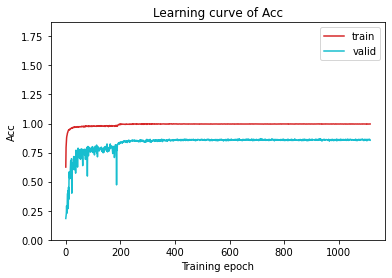

In [109]:
plot_learning_curve(train_acc_list, val_acc_list, 'Acc')

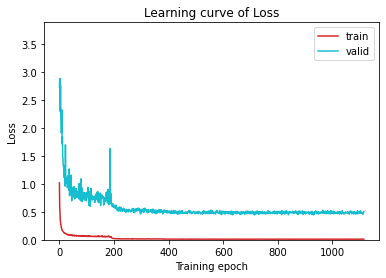

In [110]:
plot_learning_curve(train_loss_list, val_loss_list, 'Loss')

In [111]:
model = Classifier().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

model.eval() # set the model to evaluation mode
train_predict = []
err = 0
for i, data in enumerate(train_loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability

    for y in test_pred.cpu().numpy():
        train_predict.append(y)

Ein = np.mean(np.array(train_predict) != train_y)
F1in = metrics.f1_score(train_y, train_predict, average='macro')  
print(f'Ein = {round(Ein, 5)}')
print(f'F1_in = {round(F1in, 5)}')

val_predict = []
for i, data in enumerate(val_loader):
    inputs = data[0]
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability

    for y in test_pred.cpu().numpy():
        val_predict.append(y)

Eval = np.mean(np.array(val_predict) != val_y)
F1val = metrics.f1_score(val_y, val_predict, average='macro')  
print(f'Eval = {round(Eval, 5)}')
print(f'F1_val = {round(F1val, 5)}')

Ein = 0.79961
F1_in = 0.16888
Eval = 0.13014
F1_val = 0.30932


# **Deep Neural Network Test**

In [112]:
# create testing dataset
test_set = IBMDataset(X_test_std, None)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# create model and load weights from checkpoint
model = Classifier().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [113]:
predict = []
model.eval() # set the model to evaluation mode
for i, data in enumerate(test_loader):
    inputs = data
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability

    for y in test_pred.cpu().numpy():
        predict.append(y)

print(encoder_map)
print(np.bincount(predict))

{'Attitude': 0, 'Competitor': 1, 'Dissatisfaction': 2, 'No Churn': 3, 'Other': 4, 'Price': 5}
[221 168  40 945  17  18]


In [114]:
dnn_submit_result = './dnn_result.csv'

new_encoder_map = {'No Churn':0, 'Competitor': 1, 'Dissatisfaction':2, 'Attitude': 3, 'Price':4, 'Other':5}

with open(dnn_submit_result, 'w') as f:
    f.write('Customer ID,Churn Category\n')
    for i in range(len(df_test.values)):
        id = str(df_test.values[i]).replace('[\'', '')
        id = id.replace('\']', '')
        pred = new_encoder_map.get(list(encoder_map.keys())[list(encoder_map.values()).index(predict[i])])
        f.write(f'{id},{pred}\n')

In [115]:
from google.colab import files

files.download(dnn_submit_result)
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **XGBoost Train**

In [116]:
train_x, train_y, val_x, val_y = X_train[:percent], y_train[:percent], X_train[percent:], y_train[percent:]

ss = StandardScaler().fit(train_x)
train_x = ss.transform(train_x)
miss_x = ss.transform(X_train_miss)
val_x = ss.transform(val_x)
X_test_std = ss.transform(X_test)

In [117]:
classifier = XGBClassifier(
    learning_rate =0.3,
    n_estimators=20,
    max_depth=10,
    min_child_weight=1,
    gamma=0,
    subsample=0.5,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    use_label_encoder =False,
    eval_metric='mlogloss') 

In [118]:
start_time = time.time()
model = classifier.fit(train_x, train_y)
end_time = time.time()

train_predict = model.predict(train_x)
val_predict = model.predict(val_x)

In [119]:
print(f'Training use {round(end_time - start_time, 3)}s')

Training use 3.359s


In [120]:
Ein = np.mean(np.array(train_predict) != train_y)
F1in = metrics.f1_score(train_y, train_predict, average='macro')  
print(f'Ein = {round(Ein, 5)}')
print(f'F1_in = {round(F1in, 5)}')
print('XGBoost Train Score {}'.format(model.score(train_x, train_y)))
print()

Eval = np.mean(np.array(val_predict) != val_y)
F1val = metrics.f1_score(val_y, val_predict, average='macro')  
print(f'Eval = {round(Eval, 5)}')
print(f'F1_val = {round(F1val, 5)}')
print('XGBoost Valid Score {}'.format(model.score(val_x, val_y)))

Ein = 0.00234
F1_in = 0.98629
XGBoost Train Score 0.9976613657623947

Eval = 0.35863
F1_val = 0.26292
XGBoost Valid Score 0.6413682522715125


# **XGBoost Test**

In [121]:
predict = model.predict(X_test_std)
predict = np.array(predict, dtype=np.int64)

print(encoder_map)
print(np.bincount(predict))

{'Attitude': 0, 'Competitor': 1, 'Dissatisfaction': 2, 'No Churn': 3, 'Other': 4, 'Price': 5}
[347 147  32 870  13]


In [122]:
xgboost_submit_result = './xgboost_result.csv'

new_encoder_map = {'No Churn':0, 'Competitor': 1, 'Dissatisfaction':2, 'Attitude': 3, 'Price':4, 'Other':5}

with open(xgboost_submit_result, 'w') as f:
    f.write('Customer ID,Churn Category\n')
    for i in range(len(df_test.values)):
        id = str(df_test.values[i]).replace('[\'', '')
        id = id.replace('\']', '')
        pred = new_encoder_map.get(list(encoder_map.keys())[list(encoder_map.values()).index(predict[i])])
        f.write(f'{id},{pred}\n')

In [123]:
from google.colab import files

files.download(xgboost_submit_result)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Test Data Analysis**

In [124]:
svm_test = pd.read_csv(svm_submit_result)
dnn_test = pd.read_csv(dnn_submit_result)
xgboost_test = pd.read_csv(xgboost_submit_result)

In [125]:
def plotResult(dataset1, dataset2, dataset3, method):
    fig, ax = plt.subplots(1, 3, figsize=(16, 8))
    fig.suptitle('Test Data Statistics')

    counts = []
    iter = 0
    for dataset in [dataset1, dataset2, dataset3]:
        freq = dataset.groupby('Churn Category').size()
        print(f'====== {method[iter]} ======')
        print(freq)
        print()

        counts = [count for _, count in freq.items()]
        x = np.arange(len(counts))
        ax[iter].bar(x, counts)
        ax[iter].set_xticks([0, 1, 2, 3, 4, 5])
        ax[iter].set_xticklabels(['No Churn', 'Competitor', 'Dissatisfaction', 'Attitude', 'Price', 'Other'], rotation=90)
        ax[iter].set_title(f'{method[iter]}')
        iter += 1

    plt.show()

====== SVM ======
Churn Category
0    910
1    213
2     40
3    211
4     21
5     14
dtype: int64

====== DNN ======
Churn Category
0    945
1    168
2     40
3    221
4     18
5     17
dtype: int64

====== XGBoost ======
Churn Category
0    870
1    147
2     32
3    347
5     13
dtype: int64



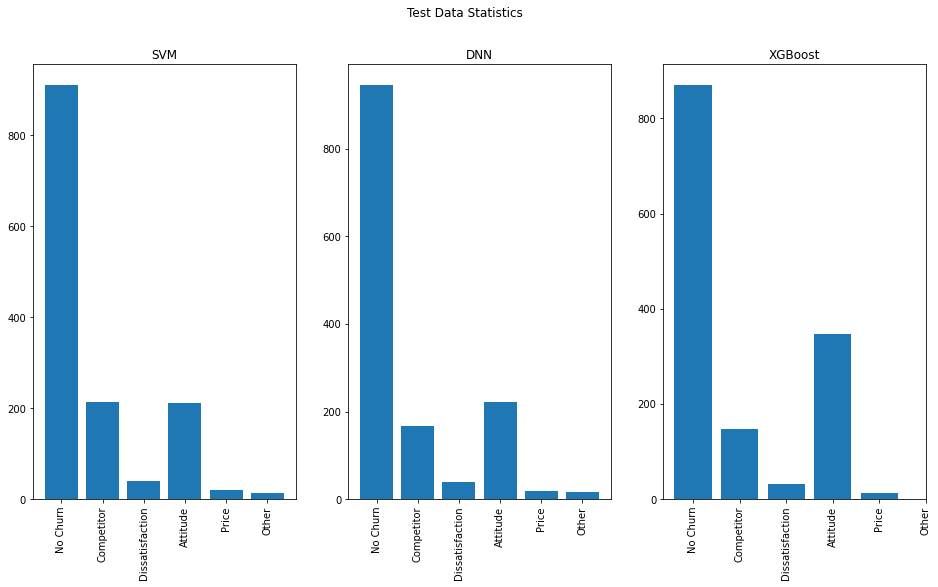

In [126]:
plotResult(svm_test, dnn_test, xgboost_test, ['SVM', 'DNN', 'XGBoost'])